In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [4]:
dataset_asimov = Dataset_load.create_asimov()

## Asimov Cases

In [5]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.0
tilt_pos =  0.0
tilt_cor = 0


bias, resolution = 0,0
print(tilt_neg)

-0.0


In [6]:

from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels, EffAreaIRFModel

effareamodel = EffAreaIRFModel()
IRFmodels = IRFModels(eff_area_model= effareamodel,
                             datasets_names = dataset_asimov.name)
print(IRFmodels.parameters.names)

['norm_nuisance', 'tilt_nuisance', 'reference']


In [7]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
dataset_cor_N = sys_d_cor.create_dataset_N(10)


sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
dataset_neg_N = sys_d_neg.create_dataset_N(10)

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
dataset_pos_N = sys_d_pos.create_dataset_N(10)

zero = 1e-24
if tilt_pos == 0:
    tilt_assumed = zero
else:
    tilt_assumed = tilt_pos
    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/shift_pos**2, 1/tilt_assumed**2])


dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]
for d in datasets:
    d.irf_model.e_reco_model.parameters.freeze_all()


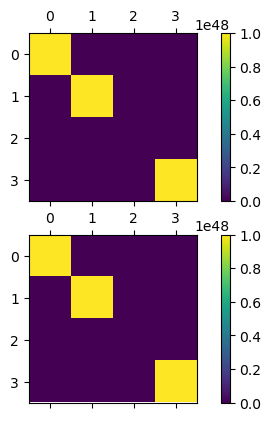

In [8]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

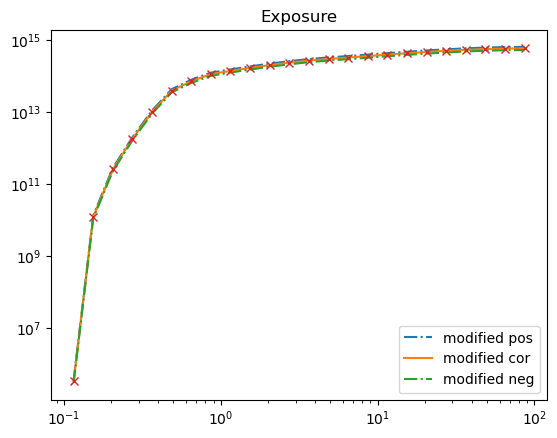

In [9]:
e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins,sum_e(dataset_pos_N.exposure.data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins,sum_e(dataset_cor_N.exposure.data ), label = 'modified cor')
plt.plot(e_bins,sum_e(dataset_neg_N.exposure.data ), label = 'modified neg', linestyle='-.')

plt.plot(e_bins,sum_e(dataset_cor_N.npred_exposure().data ), 'x')
plt.title("Exposure")

plt.legend()
plt.loglog()

[]

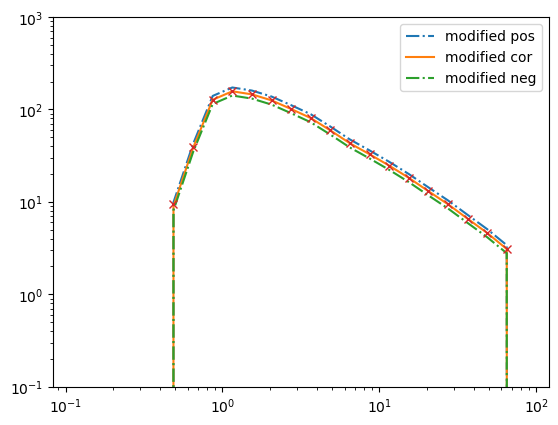

In [10]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins, sum_e(dataset_pos_N.npred_signal().data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins, sum_e(dataset_cor_N.npred_signal().data ), label = 'modified cor')
plt.plot(e_bins, sum_e(dataset_neg_N.npred_signal().data ), label = 'modified neg', linestyle='-.')

plt.plot(e_bins, sum_e((dataset_pos_N.counts- dataset_pos_N.background).data ), 'x')
plt.ylim(1e-1, 1e3)
plt.legend()
plt.loglog()

[]

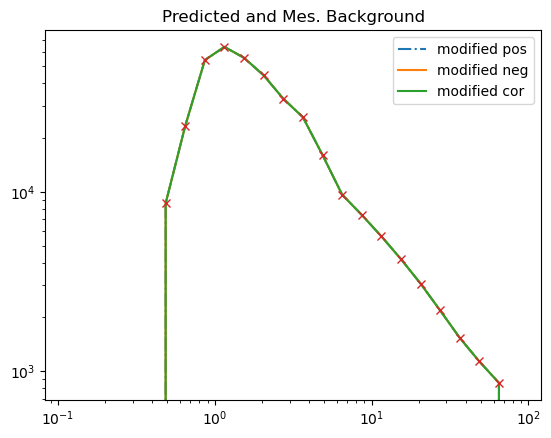

In [11]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins, sum_e(dataset_pos_N.npred_background().data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins, sum_e(dataset_neg_N.npred_background().data ), label = 'modified neg')
plt.plot(e_bins, sum_e(dataset_cor_N.npred_background().data ), label = 'modified cor')

plt.plot(e_bins, sum_e((dataset_pos_N.background).data ), 'x')
plt.title("Predicted and Mes. Background")

plt.legend()
plt.loglog()

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 203              │
│ EDM = 1.49e-07 (Goal: 2e-06)     │           time = 50.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬────

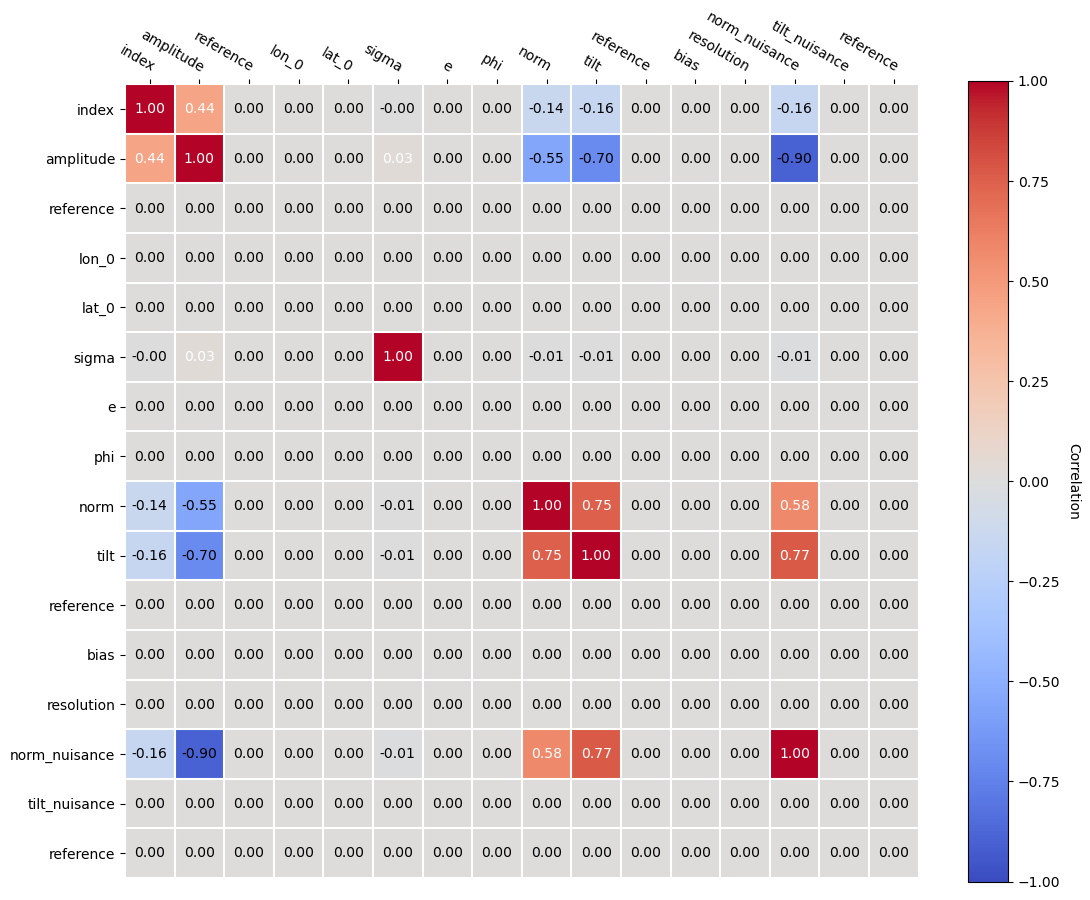

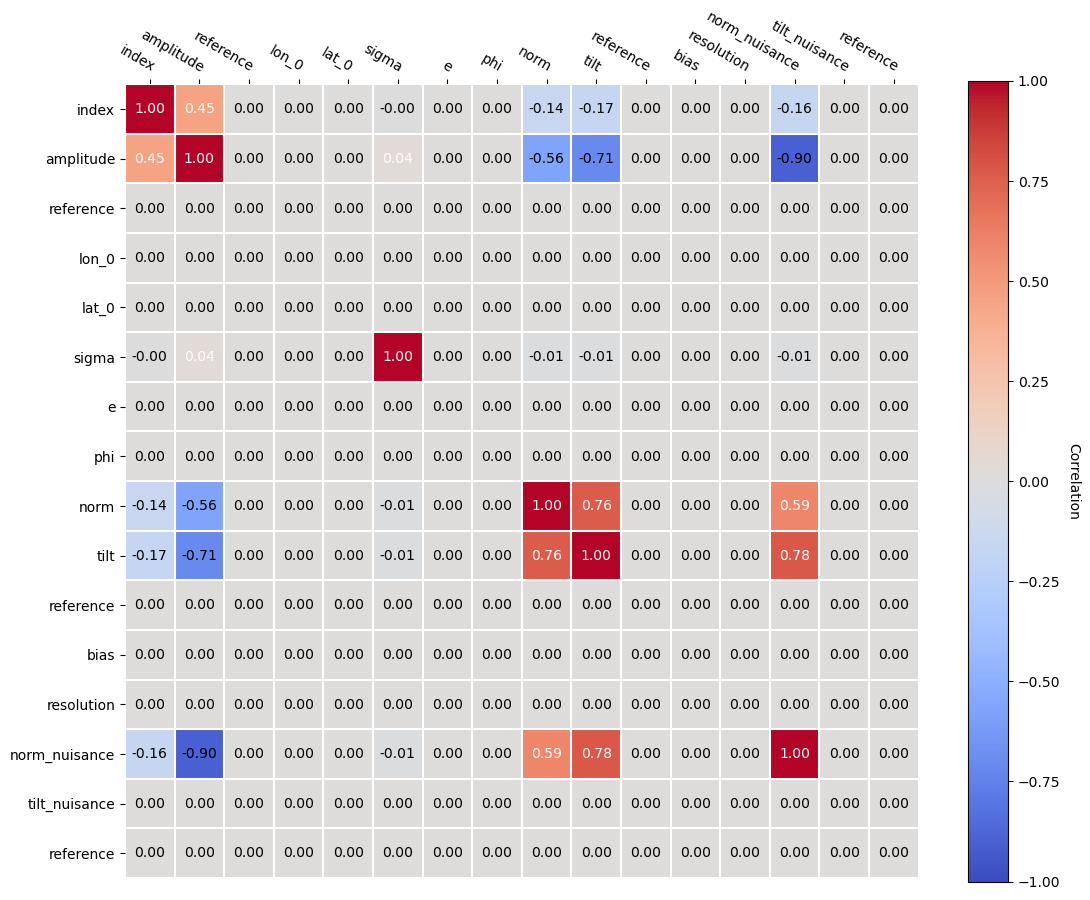

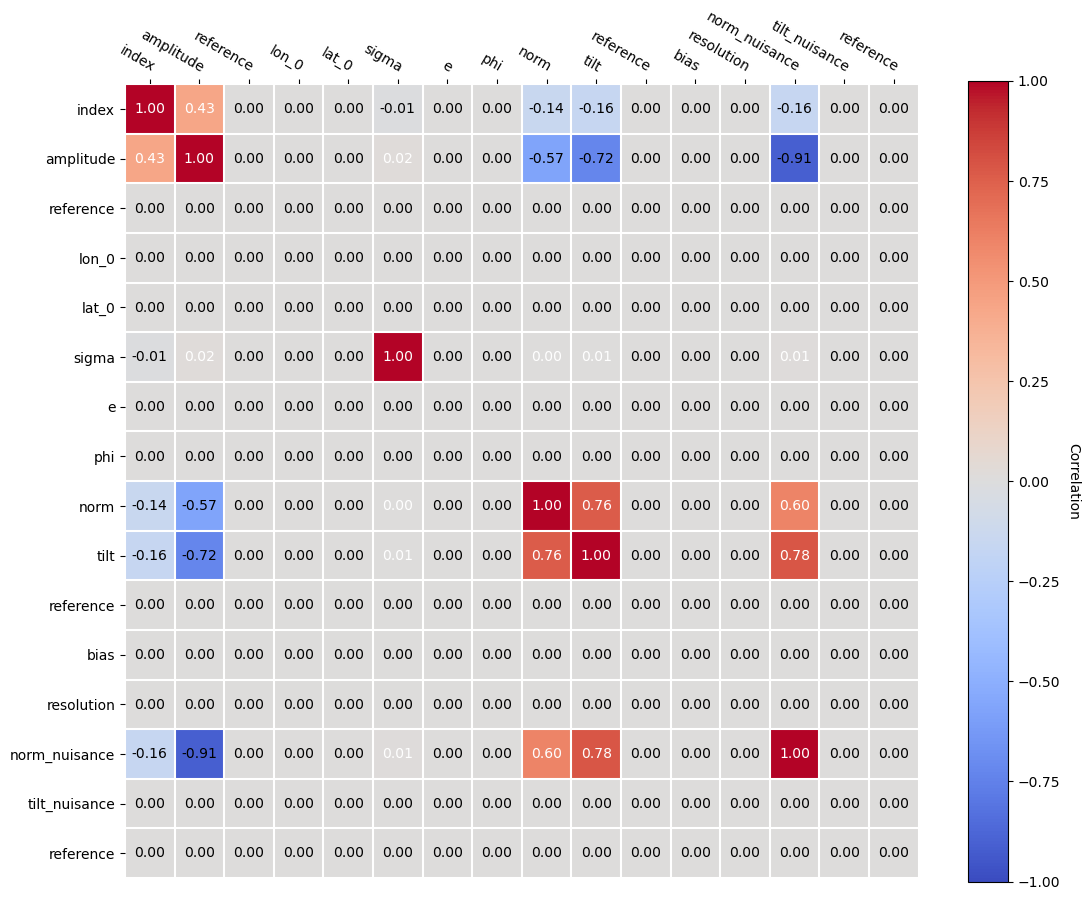

In [12]:
%%time
fitting = True

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor_N)
    dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
    dataset_cor_N.models.covariance.plot_correlation()
    print(fit_cor.minuit)

    fit_cor_N = Fit(store_trace=True)
    fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N = fit_cor_N.run(dataset_neg_N)
    dataset_neg_N.models.covariance = fit_cor_N.covariance(dataset_neg_N).matrix
    dataset_neg_N.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)
    
    
    fit_cor_N = Fit(store_trace=True)
    fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
    result_cor_N = fit_cor_N.run(dataset_pos_N)
    dataset_pos_N.models.covariance = fit_cor_N.covariance(dataset_pos_N).matrix
    dataset_pos_N.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)
    
    print("saving")
    path = f'data/2_model_nui_{shift_cor}_tilt_{tilt_cor}.yml'
    dataset_cor_N.models.write(path,overwrite=True)
    path = f'data/2_model_nui_{shift_neg}_tilt_{tilt_neg}.yml'
    dataset_neg_N.models.write(path,overwrite=True)
    path = f'data/2_model_nui_{shift_pos}_tilt_{tilt_pos}.yml'
    dataset_pos_N.models.write(path,overwrite=True)  
    
else:
    print("read")
    path = f'data/2_model_nui_{shift_cor}_tilt_{tilt_cor}.yml'
    dataset_cor_N = Dataset_load.load_dataset_N(dataset_cor_N, path)        
    path = f'data/2_model_nui_{shift_neg}_tilt_{tilt_neg}.yml'
    dataset_neg_N = Dataset_load.load_dataset_N(dataset_neg_N, path)        
    path = f'data/2_model_nui_{shift_pos}_tilt_{tilt_pos}.yml'
    dataset_pos_N = Dataset_load.load_dataset_N(dataset_pos_N, path)        
         
    



In [23]:
print(dataset_pos_N.models.parameters.penalised_parameters.names)

['bias', 'resolution', 'norm_nuisance', 'tilt_nuisance']


In [24]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
amplitudes_N = []
indices_N = []
norms_N = []
tilts_N = []


m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
value = dataset_asimov.background_model.parameters['tilt'].value 
error = dataset_asimov.background_model.parameters['tilt'].error
tilts_N.append((value, error))

for i,d in enumerate(datasets_short):
    m = d.models[0]
    
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))

    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    norms_N.append((value, error))

    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    tilts_N.append((value, error))


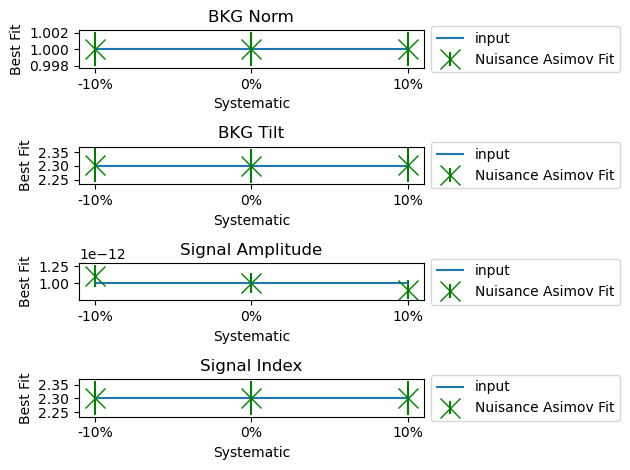

In [25]:
fig, axs = plt.subplots(4,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")


for i, a in enumerate(indices_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( indices_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    


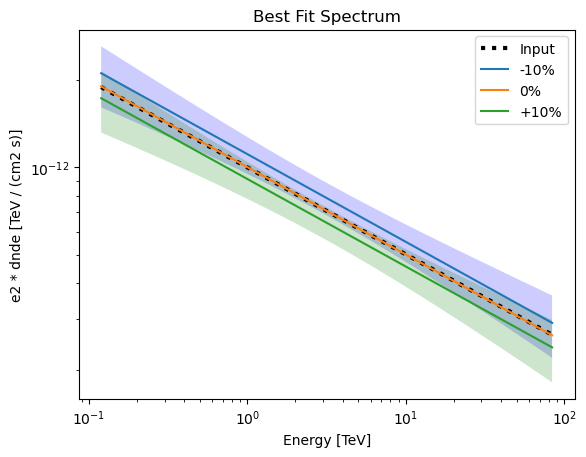

In [26]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.002548777068597273 0.10824266997137057
-7.742780441275986e-05 0.10867046567857123
-7.256759326707335e-05 0.10870565032060078
0.0 0.0
0.0 0.0
0.0 0.0


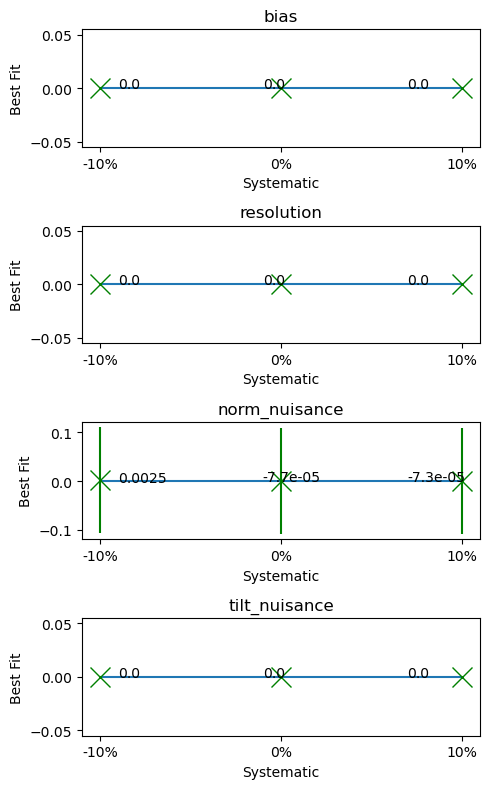

In [27]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models[-1].parameters[par_name].value
        error = d.models[-1].parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-value, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [28]:

with open('data/1_norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_tilts.yaml') as file:
    tilts = yaml.load( file, Loader=yaml.FullLoader)

In [29]:
params_N = [amplitudes_N, indices_N, norms_N, tilts_N]
params = [amplitudes, indices, norms, tilts]
names = ['amplitude', 'index', 'norm', 'tilt']

for i in range(len(names)):
    print('====')
    print("best fit " + names[i])
    print('====')
    print('Input')  
    value = params_N[i][0][0] 
    error = params_N[i][0][1]
    print(f' {value} pm {error}')
    for j,d in enumerate(datasets_short):
        if names[i] =="amplitude":
            weight = 1e12
        else:
            weight = 1
        value = params_N[i][1:][j][0]  * weight
        error = params_N[i][1:][j][1] * weight
        print(f' {value:10f} +- {error:10f}')
        value = params[i][1:][j][0]  * weight
        error = params[i][1:][j][1] * weight
        print(f'({value:10f} +- {error:10f})')
    print()

====
best fit amplitude
====
Input
 1e-12 pm 0
   1.110919 +-   0.161646
(  1.110531 +-   0.099731)
   1.002377 +-   0.146664
(  1.000000 +-   0.090597)
   0.911939 +-   0.133486
(  0.909396 +-   0.081670)

====
best fit index
====
Input
 2.3 pm 0
   2.302475 +-   0.062010
(  2.315430 +-   0.061761)
   2.301461 +-   0.061942
(  2.300000 +-   0.062280)
   2.301842 +-   0.061948
(  2.285328 +-   0.061733)

====
best fit norm
====
Input
 1.0 pm 0
   1.000004 +-   0.002066
(  1.000002 +-   0.002066)
   1.000003 +-   0.002066
(  1.000000 +-   0.002067)
   1.000002 +-   0.002066
(  1.000000 +-   0.002066)

====
best fit tilt
====
Input
 0.0 pm 0
   0.000003 +-   0.001961
(  0.000001 +-   0.001961)
   0.000004 +-   0.001961
(  0.000000 +-   0.001964)
   0.000003 +-   0.001961
( -0.000000 +-   0.001961)



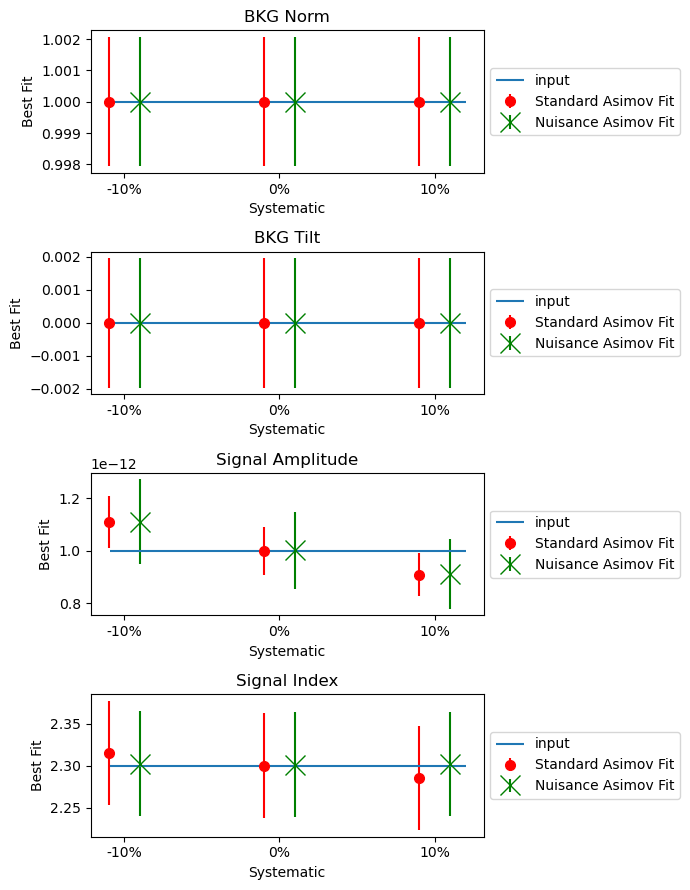

In [30]:
fig, axs = plt.subplots(4,1, figsize= (7, 9))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(tilts[1:]):
    label = "Standard Asimov Fit"
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(tilts_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)

axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( tilts[0][0], 0.91, 3.2, label = "input")
axs[2].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[3].hlines( indices[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [31]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [32]:
for d in datasets:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

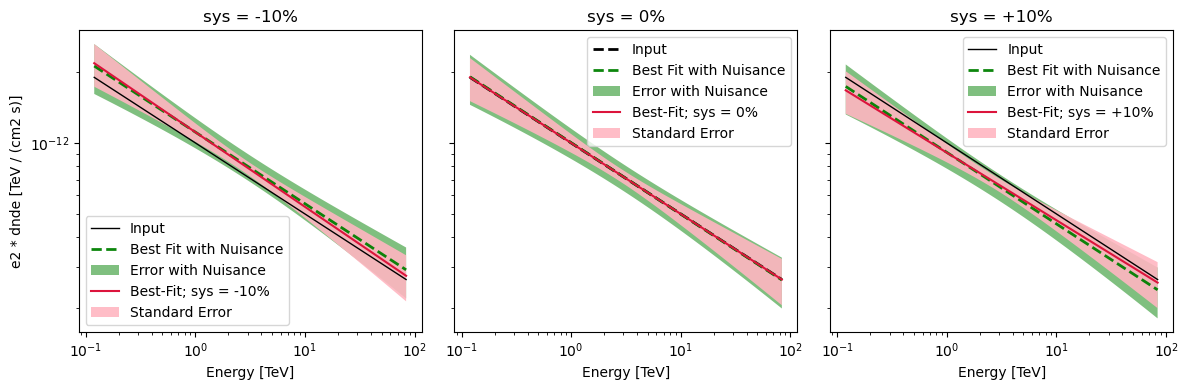

In [33]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.pdf")